<a href="https://polly.elucidata.io/manage/workspaces?action=open_polly_notebook&source=github&path=path_place_holder&kernel=elucidata/Single-cell Downstream&machine=large" target="_parent"><img src="https://elucidatainc.github.io/PublicAssets/open_polly.svg" alt="Open in Polly"/></a>


# Welcome to Pollyglot Notebook to get started with Merging gct files for any Downstream Analysis

## Here we have taken the case of Proteomics data from CPTAC.

This notebook allows you to get started with analysis of Proteomics data on Polly

<blockquote>When you first open the notebook, please run the code cells below.</blockquote>

For more details on how to use Notebooks on Polly, please visit [Polly Notebooks](https://docs.elucidata.io/Scaling%20compute/Polly%20Notebooks.html).

For more details on API access to your OmixAtlas, please visit [Accessing OmixAtlas using polly-python through Polly Notebooks](https://docs.elucidata.io/OmixAtlas/Polly%20Python.html).

In [8]:
# please do not modify
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

## Installing and Importing Packages

In [9]:
# installing packages
!sudo pip3 install polly-python --quiet 
!sudo pip3 install seaborn sklearn plotly --quiet
!sudo pip3 install joblib --quiet# to install joblib
!sudo pip3 install cmapPy --quiet
!sudo pip3 install plotly --quiet

ERROR: rich 9.12.4 has requirement typing-extensions<4.0.0,>=3.7.4, but you'll have typing-extensions 4.1.1 which is incompatible.
ERROR: awscli 1.19.19 has requirement botocore==1.20.19, but you'll have botocore 1.26.10 which is incompatible.
ERROR: awscli 1.19.19 has requirement s3transfer<0.4.0,>=0.3.0, but you'll have s3transfer 0.5.2 which is incompatible.
ERROR: aiohttp 3.7.4 has requirement chardet<4.0,>=2.0, but you'll have chardet 4.0.0 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quiet#
You should consider upgrading vi

In [ ]:
restartkernel() #Pause for a few seconds before the kernel is refreshed

In [1]:
# importing packages

from joblib import Parallel, delayed
import os
import pandas as pd
from cmapPy.pandasGEXpress.parse import parse
from cmapPy.pandasGEXpress import GCToo
from cmapPy.pandasGEXpress import write_gct
from cmapPy.pandasGEXpress.concat import assemble_common_meta
from cmapPy.pandasGEXpress.concat import assemble_data
from polly.omixatlas import OmixAtlas
from polly.workspaces import Workspaces
import urllib.parse as urlparse
from urllib.parse import parse_qs
from json import dumps
import numpy as np
import plotly.express as px
import seaborn as sns
import plotly.figure_factory as ff
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
# please do not modify
from IPython.display import HTML
HTML('''<script type="text/javascript"> Jupyter.notebook.kernel.execute("url = '" + window.location + "'", {}, {}); </script>''')

## Extracting Information of Selected Dataset
Here, information of user's selected dataset is stored in some variables to extract similar datasets from cptac and comparing them.

In [4]:
# Fetching dataset of interest
dataset_id = "01CO005_proteomics"
repo_id = "1609924165364"
repo_name ="cptac"
file_name = dataset_id+'.h5ad'

In [11]:
AUTH_TOKEN=(os.environ['POLLY_REFRESH_TOKEN']) # Obtain authentication tokens
omixatlas = OmixAtlas(AUTH_TOKEN)

query=f"SELECT * FROM {repo_name}.datasets WHERE dataset_id = '{dataset_id}'"
results=omixatlas.query_metadata(query)
display(results)

# saving specific information in variables
if results.data_type[0] == 'Proteomics':
    data_ex = results.data_type[0]
    tissue_ex = results.curated_tissue[0].strip('][').split(', ')
    disease_ex = results.curated_disease[0].strip('][').split(', ')

Query execution succeeded (time taken: 1.15 seconds, data scanned: 0.086 MB)
Fetched 1 rows


,curated_organism,src_uri,total_num_samples,repo,description,curated_cell_line,data_table_name,data_table_version,sample_type,donor_age,platform,timestamp_,file_type,publication,curated_cell_type,key,src_repo,package,file_location,curation_version,dataset_id,curated_disease,curated_drug,experimental_design,version,bucket,curated_tissue,dataset_source,data_type,is_current,region,operation,donor_gender
0,['Homo Sapiens'],polly:data://cptac/data/Colon Cancer Therapeut...,1,cptac,Protein values for 01CO005 in colon cancer,[None],cptac__01co005_proteomics,0,Tumor,NaN,LC-MS/MS,1653491115574,gct,https://doi.org/10.1016/j.cell.2019.03.030,[None],cptac/data/Colon Cancer Therapeutic Opportunit...,cptac,cptac/data,https://discover-prod-datalake-v1.s3-us-west-2...,g3,01CO005_proteomics,[Colonic Neoplasms],[None],NaN,0,discover-prod-datalake-v1,[colon sigmoideum],CPTAC,Proteomics,True,us-west-2,"{'is_normalized': 'true', 'normalized_type': '...",NaN


## Extracting Similar Types of Datasets for Analysis
On the basis of user's selected dataset information, similar type of datasets are extracted from cptac and merging their gct files into one dataframe on the basis of sample information. Each column in that dataframe represents one dataset and each row represent the sample information (which can be any antibody or antigen etc).

In [12]:
AUTH_TOKEN=(os.environ['POLLY_REFRESH_TOKEN']) # Obtain authentication tokens
omixatlas = OmixAtlas(AUTH_TOKEN)

### Dowmload the data parallely

def download_dataset(repo, id):
    """
    Downloads a single dataset with given repo_id and dataset_id
    """
    repo_id = repo
    dataset_id = id
    file_name = f"{dataset_id}.gct"
    data = omixatlas.download_data(repo_id, dataset_id)
    url = data.get('data').get('attributes').get('download_url')
    status = os.system(f"wget -O '{file_name}' '{url}'")
    if status == 0:
        print("Downloaded data successfully")
    else:
        raise Exception("Download not successful")
        
### Read gcts parallely

def read_gcts(dataset_ids):
    gct_files = [dataset_id+'.gct' for dataset_id in dataset_ids]
    results_gct = Parallel(n_jobs=4)(delayed(parse)(gct_file) for gct_file in gct_files)
    return results_gct

diseases_condition = ""
for disease in disease_ex:
    if not len(diseases_condition) == 0:
        diseases_condition += " OR "
    diseases_condition += f"CONTAINS (curated_disease, '{disease}')"

tissue_condition = ""
for tissue in tissue_ex:
    if not len(tissue_condition) == 0:
        tissue_condition += " AND "
    tissue_condition += f"CONTAINS (curated_tissue, '{tissue}')"

In [17]:
pd.options.display.max_columns = None

# quering for more datasets of similar type
query = """SELECT * FROM cptac.datasets WHERE data_type = '%s' AND %s AND %s """ %(data_ex, diseases_condition,tissue_condition)
results=omixatlas.query_metadata(query)
#  
# merging the all datasets and processing them on the basis of samples used in datasets
dataset_ids = results["dataset_id"]
dataset_ids = dataset_ids.tolist()

Parallel(n_jobs=20)(delayed(download_dataset)(repo_name, i) for i in dataset_ids)
results_gct = read_gcts(dataset_ids)

### Merge gcts
gct_files = [dataset_id+'.gct' for dataset_id in dataset_ids]

# Merging columns information
All_Metadata_col = assemble_common_meta([i.col_metadata_df for i in results_gct], 
                                    fields_to_remove = [], sources = gct_files, 
                                    remove_all_metadata_fields = False, error_report_file = 'errors')
                                    
print("\nColumns/Datasets information")
display(All_Metadata_col.head())

# Merging rows information
All_Metadata_row = assemble_common_meta([i.row_metadata_df for i in results_gct], 
                                    fields_to_remove = [], sources = gct_files, 
                                    remove_all_metadata_fields = False, error_report_file = 'errors')
                                    
print("\nRows information")
display(All_Metadata_row.head())

# Merging all the columns/datasets on the basis of rows information of each dataset
df_real = assemble_data([i.data_df for i in results_gct], concat_direction = 'horiz')
print("\nData Matrix")
display(df_real.head())

Query execution succeeded (time taken: 1.67 seconds, data scanned: 0.088 MB)
Fetched 37 rows

Columns/Datasets information


chd,Age,CEA,CIN,ESTIMATEScore,Gender,ImmuneScore,Integrated.Phenotype,Lymphatic_Invasion,Mucinous,Mutation_Phenotype,Perineural_Invasion,Polyps_History,Polyps_Present,Proteomic_subtype,Sample_Tumor_Normal,Stage,StromalScore,Subsite,Synchronous_Tumors,Transcriptomic_subtype,Tumor.Status,TumorPurity,Vascular_Invasion,Vital.Status,immuneSubtype,kw_curated_cell_line,kw_curated_cell_type,kw_curated_disease,kw_curated_drug,kw_curated_genetic_mod_type,kw_curated_modified_gene,kw_curated_tissue,mutation_rate,pathalogy_N_stage,pathalogy_T_stage
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01CO005,838,1,CIN.high,-1529.3246,Female,-427.0268,Epithelial,No,Not Mucinous,MSS,No,Yes,Yes,E,Tumor,Stage II,-1102.2979,Sigmoid Colon,No,CMS2,Tumor free,0.9285,No,Deceased,1.0,none,none,Colonic Neoplasms,none,none,none,colon sigmoideum,10.4000,N0,T3
01CO013,695,none,CIN.high,-42.0787,Male,509.0033,Epithelial,No,Not Mucinous,MSS,No,Yes,No,none,Tumor,Stage I,-551.0820,Sigmoid Colon,No,CMS3,Tumor free,0.8260,No,Living,1.0,none,none,Colonic Neoplasms,none,none,none,colon sigmoideum,29.5000,N0,T2
01CO014,930,3.6,CIN.high,-188.8456,Female,636.0912,Hypermutated,No,Mucinous,MSI-H,Yes,Yes,No,none,Tumor,Stage III,-824.9369,Hepatix Flexure,No,CMS3,With tumor,0.8380,No,Living,3.0,none,none,Colonic Neoplasms,none,none,none,Hepatix Flexure,39.7667,N2a,T3
01CO019,757,3.5,CIN.high,-904.3177,Female,-168.7173,Epithelial,Yes,Mucinous,MSS,Yes,No,No,E,Tumor,Stage III,-735.6004,Sigmoid Colon,Yes,CMS2,With tumor,0.8905,Yes,Living,1.0,none,none,Colonic Neoplasms,none,none,none,colon sigmoideum,5.0667,N2a,T4a
05CO002,none,1.1,CIN.high,2262.9769,Female,865.5989,EMT,No,Not Mucinous,MSS,No,No,No,D,Tumor,Stage III,1397.3780,Sigmoid Colon,No,CMS4,Tumor free,0.5921,No,Living,2.0,none,none,Colonic Neoplasms,none,none,none,colon sigmoideum,5.6667,N1a,T2



Rows information


""
rid
A1BG
A1CF
A2M
AAAS
AACS



Data Matrix


cid,01CO005,01CO013,01CO014,01CO019,05CO002,05CO011,05CO026,05CO029,05CO037,05CO047,05CO049,06CO002,09CO018,09CO019,11CO005,11CO008,11CO018,11CO020,11CO021,11CO022,11CO027,11CO032,11CO037,11CO039,11CO042,11CO047,11CO054,11CO070,11CO079,15CO001,15CO002,16CO002,16CO003,16CO006,21CO006,21CO007,22CO004
rid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1BG,-1.1000,-1.890,-0.523,-0.3110,-1.1400,-0.3650,-0.7360,-0.902,-1.7400,-1.580,-2.190,-0.6500,-0.8840,-0.133,0.350,0.370,-0.240,-0.957,0.1080,-0.2180,-1.090,-0.0487,0.6310,-0.4280,-0.5940,-0.3530,-0.7580,-0.297,-0.2410,-1.060,-0.9190,-0.539,-0.577,0.1780,-0.557,-0.975,-1.280
A1CF,0.3180,0.112,-0.248,-0.2700,0.3850,-0.4350,0.3380,-0.391,-1.5000,0.999,0.303,0.0887,0.0334,-0.641,-0.856,-0.224,-1.080,0.193,0.0599,0.2920,0.236,-0.2600,-0.1390,0.5660,0.4180,-0.5200,0.7320,-1.060,-0.0416,0.507,-0.0321,0.511,-0.165,0.0866,-0.447,0.398,0.518
A2M,-0.4870,-0.329,-0.638,-0.9210,-1.3700,-1.1600,-0.7380,-1.240,-1.0200,-1.840,-1.300,-0.9100,-1.3900,0.470,-0.416,-0.653,-0.897,-0.969,-0.7180,-0.8510,-1.040,-1.0900,0.0553,-0.9930,-0.3880,-0.3210,-1.1900,-0.789,0.1140,-0.966,-1.1700,-1.020,-0.810,-0.5250,0.342,-1.150,-0.872
AAAS,0.0995,0.670,0.289,0.2260,0.0167,-1.0400,0.0415,0.138,-0.0581,0.258,0.164,0.2240,-0.1040,-0.193,-0.253,-0.142,0.177,0.400,0.2750,0.1840,0.307,-0.5010,-0.2700,0.3090,0.4290,-0.0813,-0.0936,0.518,0.5110,0.455,0.2910,0.197,-0.224,-0.1290,-0.139,0.573,0.258
AACS,0.1550,0.116,0.378,0.0528,0.2120,0.0076,0.2830,-0.195,0.4700,0.846,0.111,-0.4850,0.0850,-0.117,0.257,0.225,0.538,0.592,0.1900,-0.0488,0.053,0.3180,-0.2150,0.0175,-0.0136,-0.3800,-0.1070,-1.090,0.1920,-0.248,0.4240,-0.734,-0.220,-0.1450,0.140,-0.128,0.424


# Datasets Distribution

Select the multiple column names of your choice by pressing 'ctrl' key.

Here, information of datasets/columns are shown in sunburst plot.

In [18]:
# Sunburst plot for dataset distribution
col_metadata = All_Metadata_col.loc[df_real.columns].reset_index() # Extracting datasets information
col_metadata = col_metadata.fillna("NA")

# Processing and sorting the dataset information
df = col_metadata[col_metadata.columns]
df = pd.DataFrame(df.nunique()).reset_index()
df = df.sort_values(by =[0]) 
df = df[((df[0]>1) & (df[0]< len(df_real.columns)/2))]
lst = df["chd"].to_list()
bor = []
def dropdown_handler(change):
    global bor
    bor = change.new
select_column_names = widgets.SelectMultiple(options=lst,value=['Gender'],rows=10,description='Column Data',disabled=False)
select_column_names.observe(dropdown_handler, names='value')
display(select_column_names)

SelectMultiple(description='Column Data', index=(4,), options=('CIN', 'Mucinous', 'Vital.Status', 'Synchronous…

In [28]:
print(bor)
fig = px.sunburst(col_metadata, path=bor) # PLotting sunburst
fig.show()

('Gender', 'Stage', 'pathalogy_N_stage')


# Select Datasets/Column Lables for Plots
In the widget below, the user has to select which labels they would like to see in the plots below - heatmap, boxplot and barplot. 


In [21]:
# Select the labels for dataset and saving in 'bor' variable
bor = lst[0]
label_plot = widgets.Dropdown(options=lst,value=lst[0],description='Select labels for plots:',disabled=False,)
def dropdown_handler(change):
    global bor
    print(change.new)
    bor = change.new
label_plot.observe(dropdown_handler, names='value')
display(label_plot)

Dropdown(description='Select labels for plots:', options=('CIN', 'Mucinous', 'Vital.Status', 'Synchronous_Tumo…

Stage


# Heatmap Plot
As per the label preference above, representing the graphs below.

Removing genes which have less than 75% data.

Graph will show top 20 genes, having high variance.

In [29]:
# Plotting Heatmap for Datasets' samples
df_real.columns = col_metadata[bor].to_list() # cahnging names of columns as per user selection

transpose_data = df_real.copy()
transpose_data["null_val"] = transpose_data.notnull().sum(axis=1)
transpose_data = transpose_data[transpose_data["null_val"] >= int(len(transpose_data.columns)*(75/100))]

transpose_data['var'] = transpose_data.var(axis=1)
transpose_data = transpose_data.sort_values(by =['var'], ascending = False)
transpose_data = transpose_data.drop(['var'], axis = 1)
heatmap_data = transpose_data.iloc[0:20,0:len(col_metadata)]
transpose_data.columns = [f'{x}_{i}' for i, x in enumerate(transpose_data.columns, 1)] # tracking column names by adding suffix
transpose_data = transpose_data[sorted(transpose_data.columns)] # sorting column names
heatmap_data_plot = transpose_data.iloc[0:20,0:len(col_metadata)]
fig = px.imshow(heatmap_data_plot, aspect="auto") # plotting graph
fig.show()

# Box Plot 
Expression of selected gene in the selected Column names

In [30]:
lst = df_real.index
bor = lst[0]
label_plot = widgets.Dropdown(options=lst,value=lst[0],description='Select Gene:',disabled=False,)
def dropdown_handler(change):
    global bor
    print(change.new)
    bor = change.new
label_plot.observe(dropdown_handler, names='value')
display(label_plot)

Dropdown(description='Select Gene:', options=('A1BG', 'A1CF', 'A2M', 'AAAS', 'AACS', 'AAGAB', 'AAK1', 'AAMDC',…

AAGAB
ACTB
HBG2


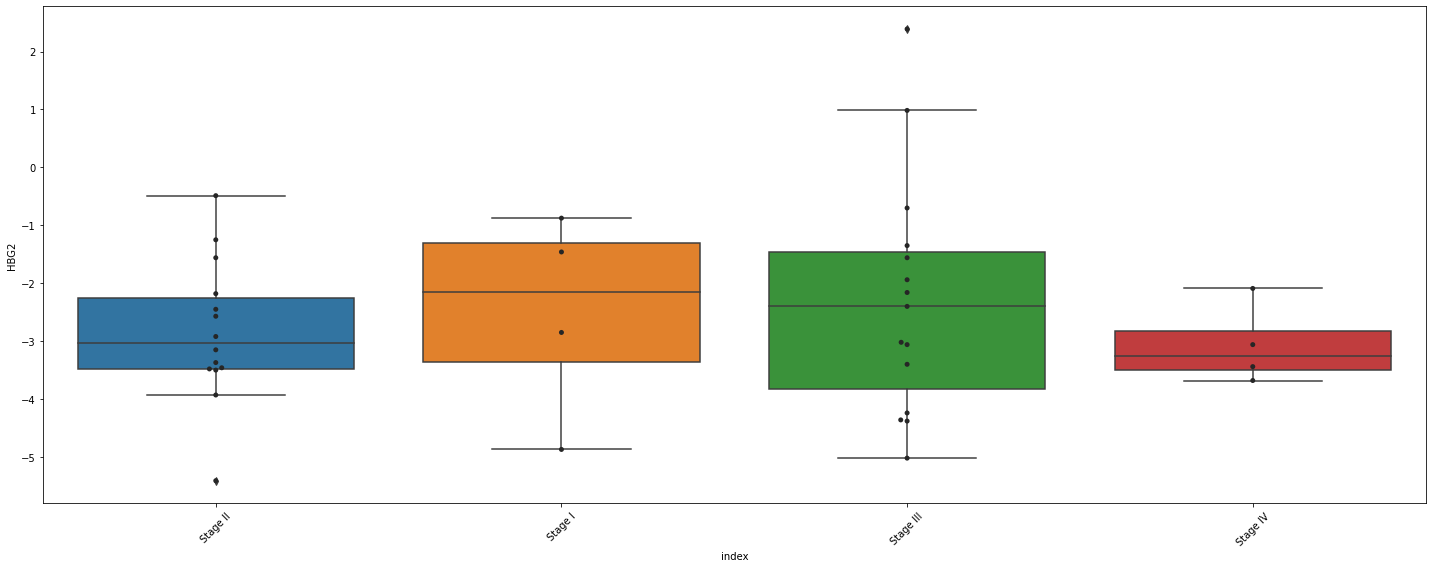

In [33]:
f = plt.figure(figsize=[20,8])
df = pd.DataFrame(df_real.loc[bor,:]).reset_index()
ax = sns.boxplot(x='index', y=bor, data=df)
ax = sns.swarmplot(x='index', y=bor, data=df, color=".15")
plt.setp(ax.get_xticklabels(), rotation=45)
f.tight_layout()

# Bar plot
Showing variations of gene expressions (row variables) among selected column labels.
Mean value was calculated for each combination in dataframe.

,Stage II,Stage I,Stage III,Stage IV
rid,,,,
HBG2,-2.837000,-2.514000,-2.281133,-3.067500
DEFA6,-2.147114,-3.077500,-1.970333,-0.647000
DES,-2.036143,-1.543000,-1.792067,-1.719750
UGT2B17,-2.180928,-2.151250,-2.399733,-2.390250
CPS1,-1.852493,-3.045000,-1.337260,-1.410000
KRT9,-2.208636,-2.427500,-2.083067,-1.887500
DEFA5,-2.117714,-2.414250,-1.799933,-0.480333
PYY,-1.959500,-1.702750,-1.922113,-1.191000
MYH11,-1.834000,-1.686250,-1.755967,-1.341750


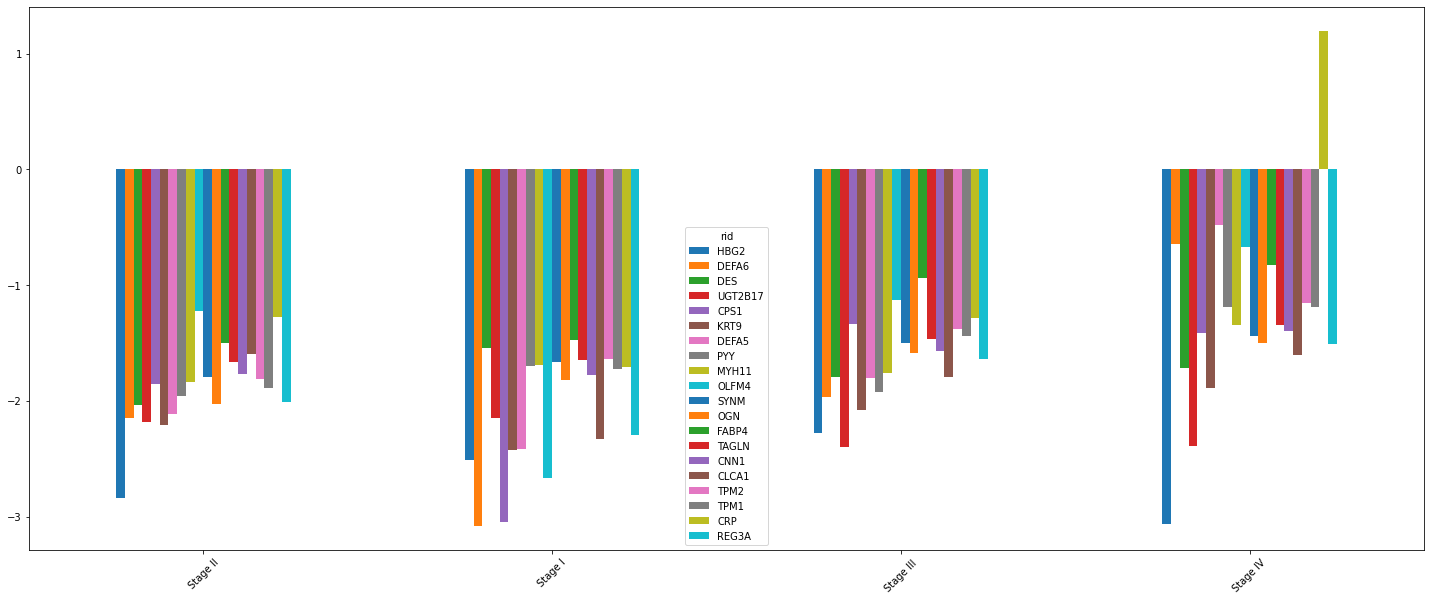

In [34]:
# Taking mean of values for each combination of dataframe
df = heatmap_data[0:20].mean(axis=1, level=0)
df.T.plot.bar(rot=45,figsize=(25, 10))
df